In [1]:
import sys, subprocess, pkgutil
def pip_install(pkgs):
    miss = [p for p in pkgs if pkgutil.find_loader(p) is None]
    if miss:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet"] + miss)
pip_install(["xgboost","gradio","shap","pandas","scikit-learn","matplotlib","numpy"])


/tmp/ipython-input-862851006.py:3: DeprecationWarning: 'pkgutil.find_loader' is deprecated and slated for removal in Python 3.14; use importlib.util.find_spec() instead
  miss = [p for p in pkgs if pkgutil.find_loader(p) is None]


In [2]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, average_precision_score, confusion_matrix, classification_report,
    f1_score, roc_curve, precision_recall_curve
)
from xgboost import XGBClassifier
import shap, gradio as gr

In [3]:
def load_creditcard_df():
    for p in ["/content/creditcard.csv", "creditcard.csv", "/mnt/data/creditcard.csv"]:
        if os.path.exists(p):
            print(f"✅ Loaded dataset from: {p}")
            return pd.read_csv(p)
    raise FileNotFoundError("Place creditcard.csv in the working directory (or /content or /mnt/data).")


In [4]:

df = load_creditcard_df()
assert "Class" in df.columns, "Dataset must contain 'Class' (0=legit, 1=fraud)"

✅ Loaded dataset from: /content/creditcard.csv


In [5]:
feature_cols = [c for c in df.columns if c != "Class"]
X = df[feature_cols].copy()
# Drop rows with NaN values in the 'Class' column before converting to integer
y = df["Class"].dropna().astype(int).copy()
X = X.loc[y.index].copy() # Align X with the cleaned y

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

In [7]:
neg, pos = int((y_train==0).sum()), int((y_train==1).sum())
spw = float(neg)/max(float(pos), 1.0)
print(f"Train distribution: legit={neg}, fraud={pos}, scale_pos_weight={spw:.2f}")


Train distribution: legit=25341, fraud=82, scale_pos_weight=309.04


In [8]:
model = XGBClassifier(
    n_estimators=300, max_depth=5, learning_rate=0.08,
    subsample=0.9, colsample_bytree=0.9, n_jobs=-1, random_state=42,
    objective="binary:logistic", eval_metric="aucpr", scale_pos_weight=spw, tree_method="hist"
)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.08, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=-1, num_parallel_tree=None, ...)

In [9]:
proba_test = model.predict_proba(X_test)[:, 1]
pred_test  = (proba_test >= 0.5).astype(int)

In [10]:
roc = roc_auc_score(y_test, proba_test)
pr  = average_precision_score(y_test, proba_test)
f1  = f1_score(y_test, pred_test)
cm  = confusion_matrix(y_test, pred_test)


In [11]:
print("\n🔎 Test Evaluation")
print(f"ROC AUC: {roc:.4f} | PR AUC: {pr:.4f} | F1: {f1:.4f}")
print("Confusion Matrix [[TN, FP], [FN, TP]]:\n", cm)
print("\nClassification Report:\n", classification_report(y_test, pred_test, digits=4))



🔎 Test Evaluation
ROC AUC: 0.9877 | PR AUC: 0.9206 | F1: 0.8500
Confusion Matrix [[TN, FP], [FN, TP]]:
 [[6333    3]
 [   3   17]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9995    0.9995    0.9995      6336
           1     0.8500    0.8500    0.8500        20

    accuracy                         0.9991      6356
   macro avg     0.9248    0.9248    0.9248      6356
weighted avg     0.9991    0.9991    0.9991      6356



In [12]:
def metrics_figure():
    fpr, tpr, _ = roc_curve(y_test, proba_test)
    prec, rec, _ = precision_recall_curve(y_test, proba_test)

    fig = plt.figure(figsize=(10,4))
    # ROC
    ax1 = fig.add_subplot(1,2,1)
    ax1.plot(fpr, tpr, label=f"AUC={roc:.3f}")
    ax1.plot([0,1],[0,1],'--')
    ax1.set_xlabel("False Positive Rate"); ax1.set_ylabel("True Positive Rate")
    ax1.set_title("ROC Curve"); ax1.legend()
    # PR
    ax2 = fig.add_subplot(1,2,2)
    ax2.plot(rec, prec, label=f"AP={pr:.3f}")
    ax2.set_xlabel("Recall"); ax2.set_ylabel("Precision")
    ax2.set_title("Precision–Recall Curve"); ax2.legend()
    fig.tight_layout()
    return fig

In [13]:
bg_size = min(2000, len(X_train))
rng = np.random.RandomState(42)
background = X_train.iloc[rng.choice(len(X_train), size=bg_size, replace=False)]

explainer = shap.TreeExplainer(model, data=background, feature_names=feature_cols)

# Sample a global subset
global_sample = X_test.sample(min(2000, len(X_test)), random_state=42)
shap_vals_global = explainer.shap_values(global_sample)
if isinstance(shap_vals_global, list): shap_vals_global = shap_vals_global[0]

mean_abs_shap = np.abs(shap_vals_global).mean(axis=0)
global_importance = (
    pd.DataFrame({"feature": feature_cols, "mean_abs_shap": mean_abs_shap})
      .sort_values("mean_abs_shap", ascending=False)
      .reset_index(drop=True)
)

In [14]:
def plot_global_importance(top_k=20):
    k = min(top_k, len(global_importance))
    sub = global_importance.head(k).iloc[::-1]
    fig, ax = plt.subplots(figsize=(7, 0.35*k + 1.2))
    ax.barh(sub["feature"], sub["mean_abs_shap"])
    ax.set_title(f"Global Feature Importance (mean |SHAP|) – Top {k}")
    ax.set_xlabel("mean(|SHAP|)")
    fig.tight_layout()
    return fig


In [15]:
def plot_local_shap_bar(x_row, shap_values, top_k=12):
    vals = np.array(shap_values).flatten()
    dfc = pd.DataFrame({"feature": feature_cols,
                        "value": x_row.values.flatten(),
                        "shap": vals})
    dfc["abs_shap"] = dfc["shap"].abs()
    dfc = dfc.sort_values("abs_shap", ascending=False).head(min(top_k, len(dfc)))
    dfc = dfc.iloc[::-1]  # big to small up the axis

    fig, ax = plt.subplots(figsize=(7, 0.4*len(dfc)+1.2))
    bars = ax.barh(dfc["feature"], dfc["shap"])
    ax.set_title("Local SHAP Contributions (Top Features)")
    ax.set_xlabel("SHAP value (impact on log-odds)")
    for bar, v in zip(bars, dfc["value"]):
        ax.text(bar.get_width() + (0.02 if bar.get_width()>=0 else -0.02),
                bar.get_y() + bar.get_height()/2,
                f"{v:.3g}", va="center",
                ha="left" if bar.get_width()>=0 else "right", fontsize=9)
    fig.tight_layout()
    return fig


In [16]:
def explain_row(idx: int):
    idx = int(np.clip(idx, 0, len(X_test)-1))
    x = X_test.iloc[[idx]]
    p = float(model.predict_proba(x)[:,1][0])
    sv = explainer.shap_values(x)
    if isinstance(sv, list): sv = sv[0]
    fig = plot_local_shap_bar(x, sv, top_k=12)
    info = {
        "row_index": idx,
        "fraud_probability": round(p, 6),
        "prediction@0.5": "FRAUD" if p>=0.5 else "LEGIT"
    }
    return info, fig

In [17]:
top_features = global_importance["feature"].head(8).tolist()

# Build robust slider ranges using quantiles
def feature_ranges(df_ref, q_low=0.01, q_high=0.99):
    ql, qh, means, stds = df_ref.quantile(q_low), df_ref.quantile(q_high), df_ref.mean(), df_ref.std(ddof=0).replace(0, np.nan)
    ranges = {}
    for f in df_ref.columns:
        lo = float(ql.get(f, df_ref[f].min()))
        hi = float(qh.get(f, df_ref[f].max()))
        mu = float(means.get(f, 0.0))
        sd = float(stds.get(f, 0.0)) if np.isfinite(stds.get(f, np.nan)) else 0.0
        if not np.isfinite(lo): lo = df_ref[f].min()
        if not np.isfinite(hi): hi = df_ref[f].max()
        if not np.isfinite(lo): lo = -1.0
        if not np.isfinite(hi): hi =  1.0
        if hi <= lo:
            pad = max(abs(mu)*0.1, abs(sd)*0.5, 1e-3)
            lo, hi = mu - pad, mu + pad
        ranges[f] = (lo, hi, mu)
    return ranges

ranges = feature_ranges(X_train)

In [18]:
def defaults_for_row(i):
    i = int(np.clip(i, 0, len(X_test)-1))
    return [float(X_test[f].iloc[i]) for f in top_features]

In [19]:
def what_if(ref_index:int, *vals):
    ref_index = int(np.clip(ref_index, 0, len(X_test)-1))
    x = X_test.iloc[[ref_index]].copy()
    for f, v in zip(top_features, vals):
        if v is None: continue
        if isinstance(v, float) and (np.isnan(v) or np.isinf(v)): continue
        x.at[x.index[0], f] = float(v)
    p = float(model.predict_proba(x)[:,1][0])
    sv = explainer.shap_values(x);
    if isinstance(sv, list): sv = sv[0]
    fig = plot_local_shap_bar(x, sv, top_k=12)
    info = {
        "reference_row": ref_index,
        "fraud_probability": round(p, 6),
        "alert": "⚠️ Fraud Likely – investigate" if p >= 0.7 else "✅ Likely Legit"
    }
    return info, fig

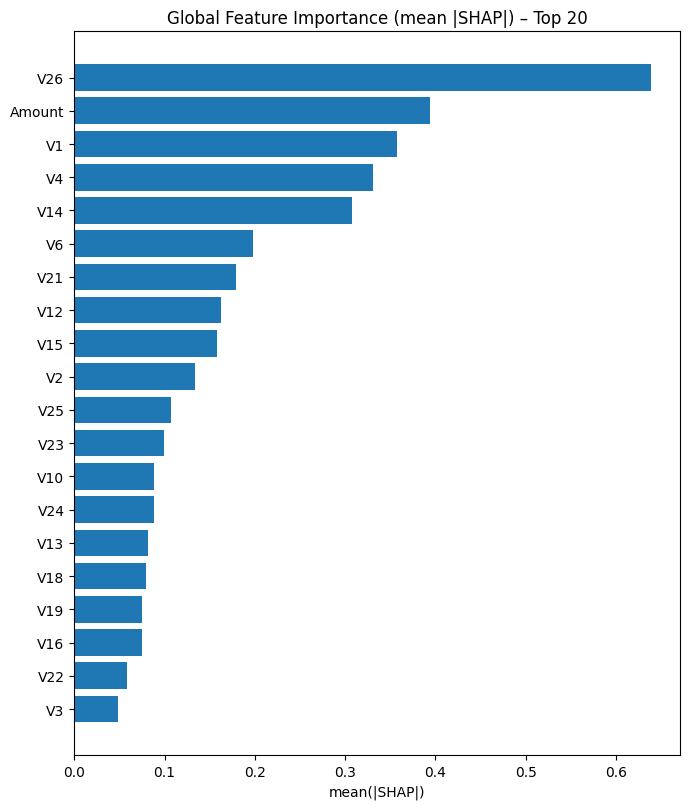

In [20]:
def batch_predict(df_upload: pd.DataFrame):
    if df_upload is None or df_upload.empty:
        return pd.DataFrame({"error": ["No data uploaded"]})
    Xu = df_upload.copy()
    if "Class" in Xu.columns: Xu = Xu.drop(columns=["Class"])
    missing = [c for c in feature_cols if c not in Xu.columns]
    if missing:
        return pd.DataFrame({"error": [f"Missing features: {missing}"]})
    Xu = Xu[feature_cols]
    probs = model.predict_proba(Xu)[:,1]
    preds = (probs >= 0.5).astype(int)
    out = df_upload.copy()
    out["fraud_proba"] = probs
    out["prediction(0=legit,1=fraud)"] = preds
    return out

GLOBAL_FIG = plot_global_importance(top_k=20)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://44f80f6111795604fd.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


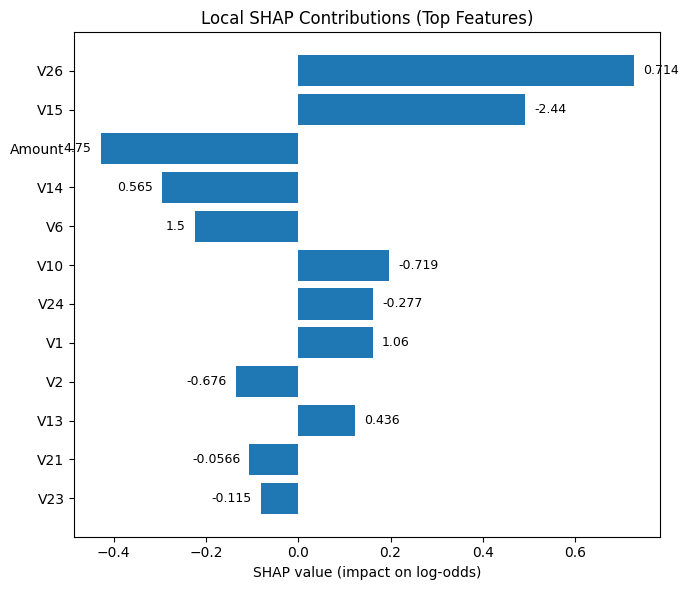

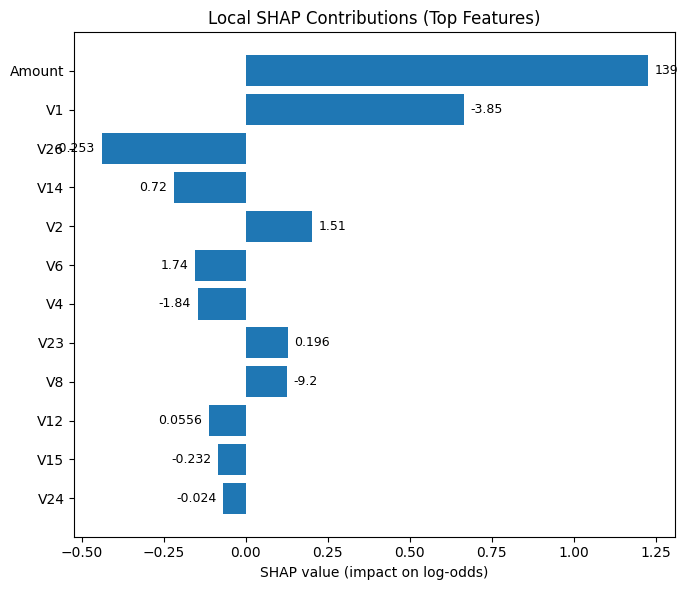

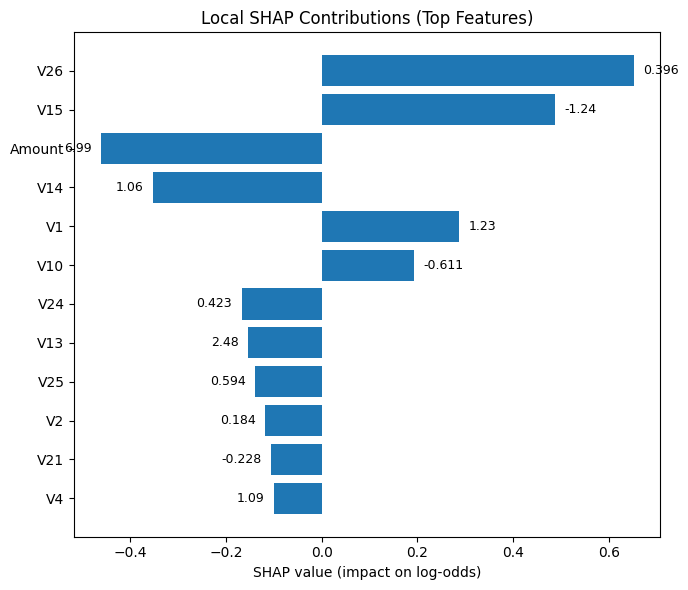

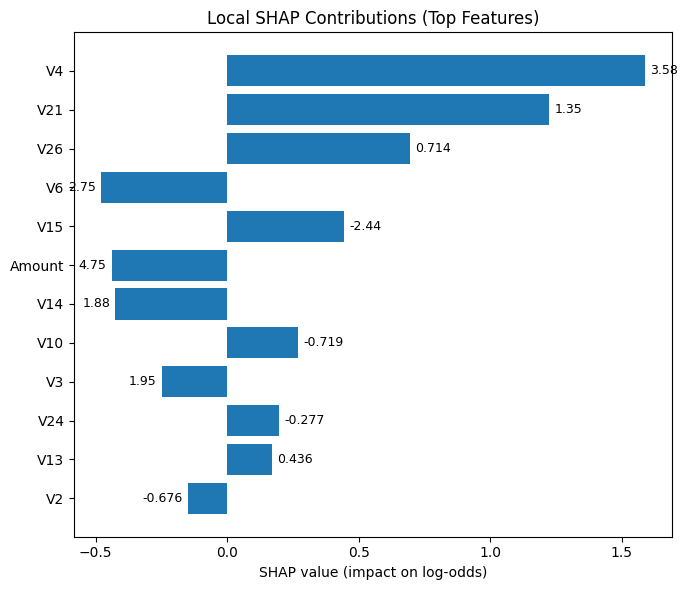

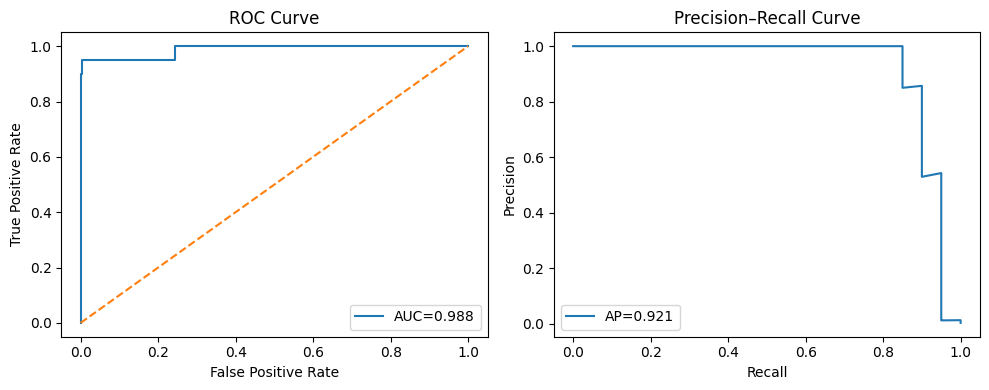

In [22]:
with gr.Blocks(title="💳 Fraud Detection – Explainable AI") as demo:
    gr.Markdown(
        f"""
# 💳 Credit Card Fraud Detection — Explainable AI Dashboard
**Model**: XGBoost (class-imbalance aware)
**Test ROC AUC**: `{roc:.4f}` &nbsp;&nbsp; **Test PR AUC**: `{pr:.4f}` &nbsp;&nbsp; **F1**: `{f1:.4f}`
**Train balance**: legit={neg}, fraud={pos} (scale_pos_weight={spw:.2f})

This app helps analysts **detect and understand** fraud:
- 📈 Model metrics (ROC/PR)
- 📊 Global feature importance (mean |SHAP|)
- 🔎 Per-row explanation (local SHAP)
- 🧪 What-If analysis on key features
- 📥 Batch scoring (CSV)
"""
    )

    # ================= Model Metrics Tab =================
    with gr.Tab("📈 Model Metrics"):
        gr.Plot(value=metrics_figure(), label="ROC & PR Curves")
        gr.JSON(
            value={"ROC AUC": round(roc, 4), "PR AUC": round(pr, 4), "F1": round(f1, 4)},
            label="Key Metrics"
        )

    # ================= Global Importance Tab =================
    with gr.Tab("📊 Global Importance"):
        gr.Markdown("Top features by mean absolute SHAP value.")
        gr.Plot(value=GLOBAL_FIG, label="Global Feature Importance")

    # ================= Local Explanation Tab =================
    with gr.Tab("🔎 Local Explanation"):
        idx_inp = gr.Slider(0, len(X_test)-1, step=1, value=0, label="Test Row Index")
        info_json = gr.JSON(label="Prediction")
        fig_out = gr.Plot(label="Local Explanation (Top Feature Impacts)")
        gr.Button("Explain Row").click(
            explain_row,
            inputs=[idx_inp],
            outputs=[info_json, fig_out]
        )

    # ================= What-If Analysis Tab =================
    with gr.Tab("🧪 What-If Analysis"):
        ref_idx = gr.Slider(0, len(X_test)-1, step=1, value=0, label="Reference Test Row")
        with gr.Accordion("Adjust Top Features", open=True):
            sliders = []
            for f in top_features:
                lo, hi, mu = ranges[f]
                default_v = float(X_test[f].iloc[0]) if f in X_test.columns else float(mu)
                step = max((hi - lo) / 200.0, 1e-6)
                sliders.append(
                    gr.Slider(minimum=lo, maximum=hi, value=default_v, step=step, label=f)
                )

        def _use_row_defaults(i, *cur):
            return defaults_for_row(i)

        gr.Button("Use Row Defaults").click(
            _use_row_defaults,
            inputs=[ref_idx, *sliders],
            outputs=sliders
        )

        wi_info = gr.JSON(label="What-If Prediction")
        wi_fig = gr.Plot(label="Local Explanation (After Tweaks)")
        gr.Button("Run What-If").click(
            what_if,
            inputs=[ref_idx, *sliders],
            outputs=[wi_info, wi_fig]
        )

    # ================= Batch Predict Tab =================
    with gr.Tab("📥 Batch Predict (CSV)"):
        gr.Markdown(
            "Upload a **CSV file** with the same feature columns (`Time`, `V1–V28`, `Amount`). `Class` optional."
        )
        file_input = gr.File(file_types=[".csv"], label="Upload CSV File")
        out = gr.Dataframe(label="Predictions")

        def batch_predict_from_file(file):
            if file is None:
                return pd.DataFrame({"error": ["No file uploaded"]})
            df_upload = pd.read_csv(file.name)
            Xu = df_upload.copy()
            if "Class" in Xu.columns:
                Xu = Xu.drop(columns=["Class"])
            missing = [c for c in feature_cols if c not in Xu.columns]
            if missing:
                return pd.DataFrame({"error": [f"Missing features: {missing}"]})
            Xu = Xu[feature_cols]
            probs = model.predict_proba(Xu)[:, 1]
            preds = (probs >= 0.5).astype(int)
            out = df_upload.copy()
            out["fraud_proba"] = probs
            out["prediction(0=legit,1=fraud)"] = preds
            return out

        gr.Button("Predict").click(
            batch_predict_from_file, inputs=[file_input], outputs=[out]
        )

# ================= Launch App =================
demo.launch(share=True, show_error=True)


In [23]:
# 📊 Business KPI Analysis (Cost of Errors)
from sklearn.metrics import confusion_matrix

# Costs
FN_cost = 10000   # Missed fraud
FP_cost = 500     # Wrongly flagged legit

# Confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, pred_test).ravel()

# Business impact
business_loss = fn * FN_cost + fp * FP_cost
print("📌 Confusion Matrix:", [[tn, fp], [fn, tp]])
print(f"👉 False Negatives (missed frauds): {fn} × {FN_cost} = ₹{fn*FN_cost:,}")
print(f"👉 False Positives (legit wrongly flagged): {fp} × {FP_cost} = ₹{fp*FP_cost:,}")
print(f"💰 Estimated Business Loss on Test Set = ₹{business_loss:,}")


📌 Confusion Matrix: [[np.int64(6333), np.int64(3)], [np.int64(3), np.int64(17)]]
👉 False Negatives (missed frauds): 3 × 10000 = ₹30,000
👉 False Positives (legit wrongly flagged): 3 × 500 = ₹1,500
💰 Estimated Business Loss on Test Set = ₹31,500


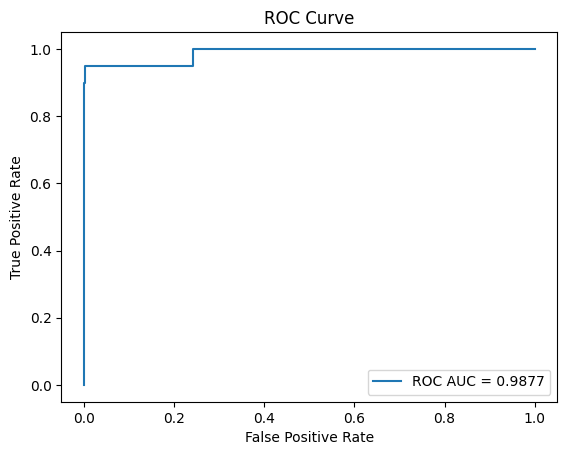

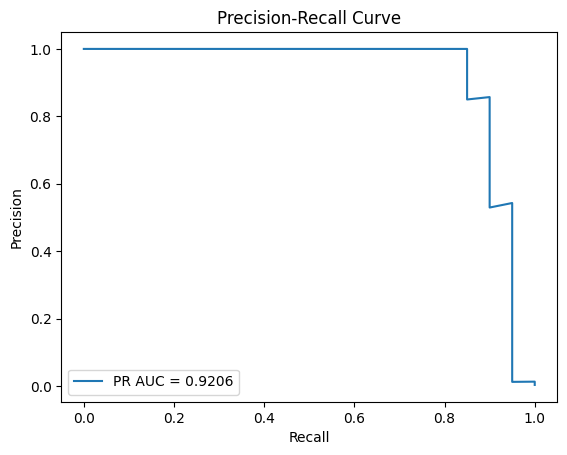

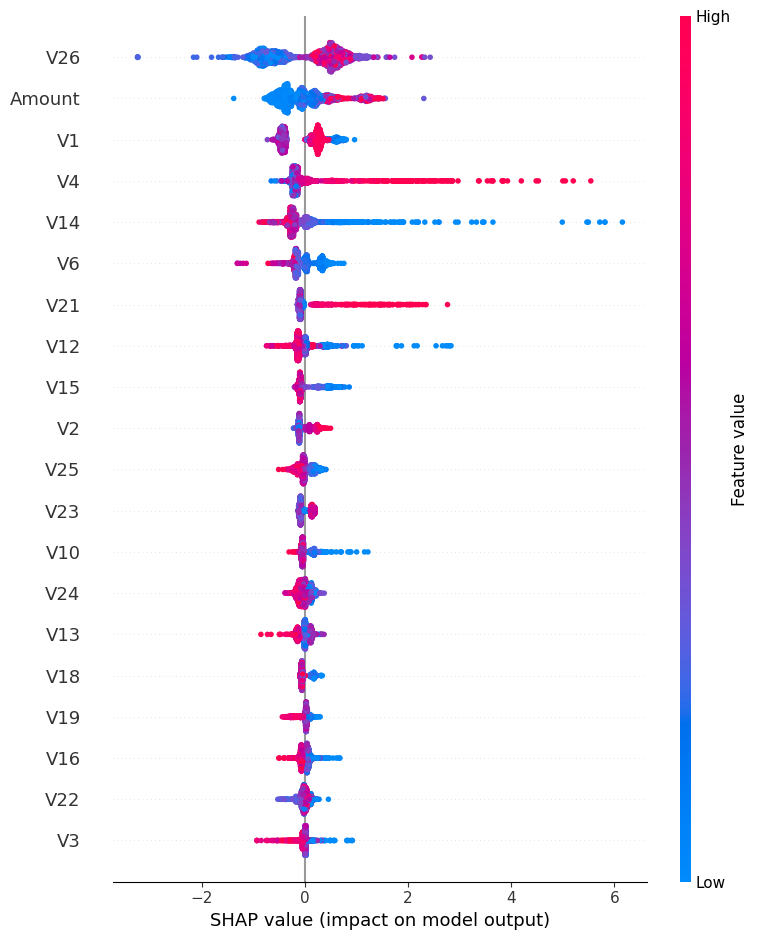

In [24]:
# 📈 Save Plots for PPT
from sklearn.metrics import precision_recall_curve, roc_curve

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, proba_test)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC AUC = {roc:.4f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.savefig("roc_curve.png", dpi=300)
plt.show()

# Precision-Recall Curve
prec, rec, _ = precision_recall_curve(y_test, proba_test)
plt.figure()
plt.plot(rec, prec, label=f"PR AUC = {pr:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.savefig("pr_curve.png", dpi=300)
plt.show()

# SHAP Beeswarm Plot
shap.summary_plot(shap_vals_global, global_sample, feature_names=feature_cols, show=False)
plt.savefig("shap_beeswarm.png", dpi=300, bbox_inches="tight")
plt.show()


In [25]:
ignore_content = """
# -----------------
# Python junk files
# -----------------
__pycache__/
*.pyc
*.pyo
*.pyd
*$py.class

# Virtual environments
venv/
env/
.venv/

# Build and packaging
build/
dist/
*.egg-info/

# -----------------
# Jupyter
# -----------------
.ipynb_checkpoints/

# -----------------
# Data files
# -----------------
*.csv
!data/sample_creditcard.csv
!data/creditcard_demo_sample.csv

*.xlsx
*.xls

# -----------------
# Models
# -----------------
*.pkl
*.joblib
*.h5
*.model

# -----------------
# System files
# -----------------
.DS_Store
Thumbs.db

# -----------------
# Logs
# -----------------
*.log
"""

with open(".gitignore", "w") as f:
    f.write(ignore_content)

print("✅ .gitignore file created in project root")


✅ .gitignore file created in project root
